# TP1 Redes Neuronales Bag Of Words
# Grupo : Anna Candela Gioia y Antonin Sibeleau

 SETUP: obtenemos los datasets de test y train. Para train se divide un parte para poder realizar cross validation.

# SETUP

In [ ]:
# SETUP
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import pickle

# Data import
twenty_train_full = fetch_20newsgroups(subset='train', shuffle=True, remove = ['headers', 'footers', 'quotes'])
twenty_test = fetch_20newsgroups(subset='test', shuffle=True, remove = ['headers', 'footers', 'quotes'])
twenty_train, x_train_for_cv, twenty_train_y, y_train_for_cv = train_test_split(twenty_train_full.data, twenty_train_full.target, test_size=0.2, random_state=42)

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# EDA

In [4]:
print('Cantidad de artículos de train',len(twenty_train_full.target))
print('Cantidad de artículos de test',len(twenty_test.target))
print('Cantidad de artículos de train split',len(twenty_train_y))
print('Cantidad de artículos para los documentos de cross validation',len(y_train_for_cv))
print('Temas de los artículos de train', twenty_train_full["target_names"])
print('Temas de los artículos de test', twenty_test["target_names"])


Cantidad de artículos de train 11314
Cantidad de artículos de test 7532
Cantidad de artículos de train split 9051
Cantidad de artículos para los documentos de cross validation 2263
Temas de los artículos de train ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Temas de los artículos de test ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politi

# Preprocess

Realizamos distintos procedimientos teniendo en cuenta las distintas formas de filtrar.

Basic:
* Token

Normal:
* Lematización para verbos
* Stop Words

Complete:
* Lematización para verbos
* Stop Words
* Stemming

In [5]:
# PREPROCESSING
def preprocess_data(data):
    basic_preprocessed_data = list()
    normal_preprocessed_data = list()
    complete_preprocessed_data = list()
    for article in tqdm(data):
        tokens = word_tokenize(article)
        basic_preprocessed_data.append(" ".join(tokens))
        lem = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
        stop = [token for token in lem if token not in stopwords.words('english')]
        normal_preprocessed_data.append(" ".join(stop))
        stem = [stemmer.stem(token) for token in stop]
        alpha = [token for token in stem if token.isalpha()]
        complete_preprocessed_data.append(" ".join(alpha))
    return basic_preprocessed_data, normal_preprocessed_data, complete_preprocessed_data

basic_preprocessed_train_data, normal_preprocessed_train_data, complete_preprocessed_train_data = preprocess_data(twenty_train) #twenty_train.data #split of train to train
basic_preprocessed_train_data_cv, normal_preprocessed_train_data_cv, complete_preprocessed_train_data_cv = preprocess_data(x_train_for_cv)#split of train to test
basic_preprocessed_test_data, normal_preprocessed_test_data, complete_preprocessed_test_data = preprocess_data(twenty_test.data)#test
basic_preprocessed_train_data_full, normal_preprocessed_train_data_full, complete_preprocessed_train_data_full= preprocess_data(twenty_train_full.data)#full train

100%|██████████| 11314/11314 [07:47<00:00, 24.18it/s]


# Búsquedad de Hiperparámetros Naive Bayes

Ya reducido el vocabulario, se puede determinar los min_df y max_df.

In [28]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


def histogram_min_max_df(data, type):
  vc = CountVectorizer()
  X_train_data=vc.fit_transform(data)


  vocabulary = vc.get_feature_names_out()
  document_frequency = np.array(X_train_data.astype(bool).sum(axis=0)).flatten()
  plt.hist(document_frequency, bins = 500 )
  plt.yscale('log')
  if (type == 0):
    plt.title('Histogram DF Normal')
  elif (type == 1):
    plt.title('Histogram DF Basic')
  elif (type == 2):
    plt.title('Histogram DF Complete')
  plt.xlabel('DF')
  plt.ylabel('Frequency')
  plt.show()
  print('\n')

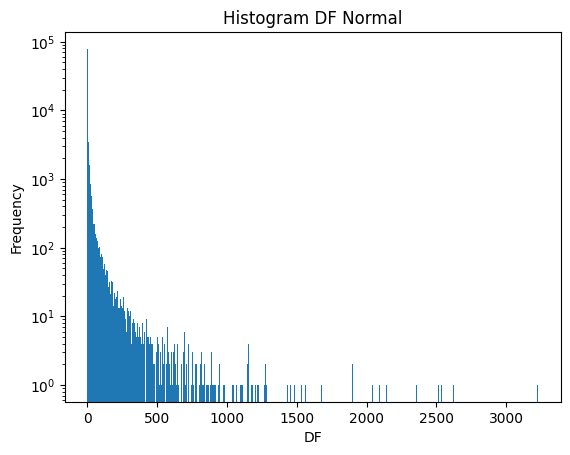

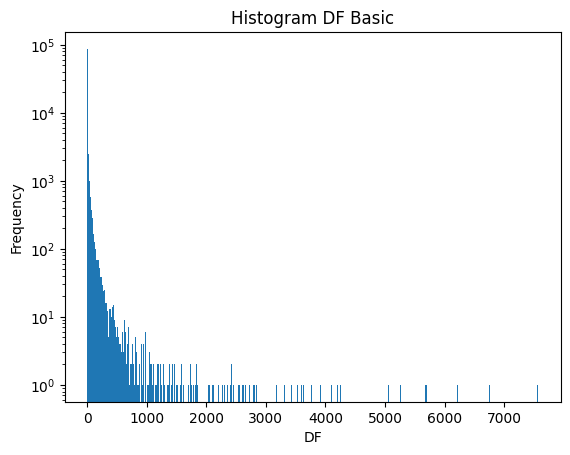

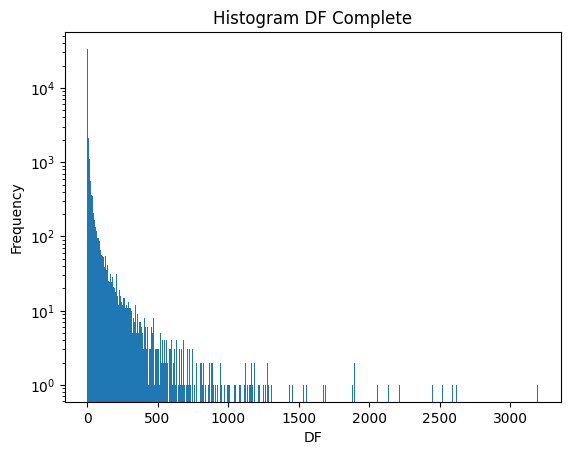

In [29]:
histogram_min_max_df(normal_preprocessed_train_data,0)
histogram_min_max_df(basic_preprocessed_train_data,1)
histogram_min_max_df(complete_preprocessed_train_data,2)


In [26]:
# FINDING min_df and max_df
def find_min_max_df(preprocessed_train_data, preprocessed_test_data,y_train_for_cv,twenty_train_y , debug=False):
    # Finding min_df and max_df
    best_accuracy = 0
    best_min_df = None
    best_max_df = None

    # Values to test
    min_df_values = [0, 0.1, 0.2, 0.3]
    max_df_values = [0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

    # Create a single figure for all plots
    fig, axs = plt.subplots(len(min_df_values)//2, len(min_df_values)//2, figsize=(8, 4))

    for idx, min_df in enumerate(min_df_values):
        row = idx // 2
        col = idx % 2
        accuracies = []  # Keep accuracies for each max_df
        for max_df in max_df_values:
            if min_df < max_df:
                # Data vectorization
                vectorizer_train = CountVectorizer(min_df=min_df, max_df=max_df)
                X_train = vectorizer_train.fit_transform(preprocessed_train_data)
                vectorizer_test = CountVectorizer(vocabulary=vectorizer_train.vocabulary_)
                X_test = vectorizer_test.transform(preprocessed_test_data)

                # Training
                clf = MultinomialNB()
                clf.fit(X_train, twenty_train_y)  #antes decía twenty_train

                # Evaluation
                accuracy = np.mean(clf.predict(X_test) == y_train_for_cv) #antes decía twenty_test.target
                accuracies.append(accuracy)

                # Print accuracy if debug mode is enabled
                if debug:
                    print(f"min_df={min_df}, max_df={max_df} - Accuracy: {accuracy}")

                # Update parameters
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_min_df = min_df
                    best_max_df = max_df

            else:
                accuracies.append(None)

        # Plot accuracies for current min_df
        axs[row, col].plot(max_df_values, accuracies, marker='o')
        axs[row, col].set_title(f'Accuracy vs. max_df for min_df={min_df}')
        axs[row, col].set_xlabel('max_df')
        axs[row, col].set_ylabel('Accuracy')
        axs[row, col].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap of subplots
    plt.show()

    return best_min_df, best_max_df, best_accuracy


Procedemos a graficar el score/accuracy en función de los parámetros.
Obtenemos el mind_df y max_df entrenando con una parte de train (twenty_train) y testeando con otra parte (x_train_for_cv).

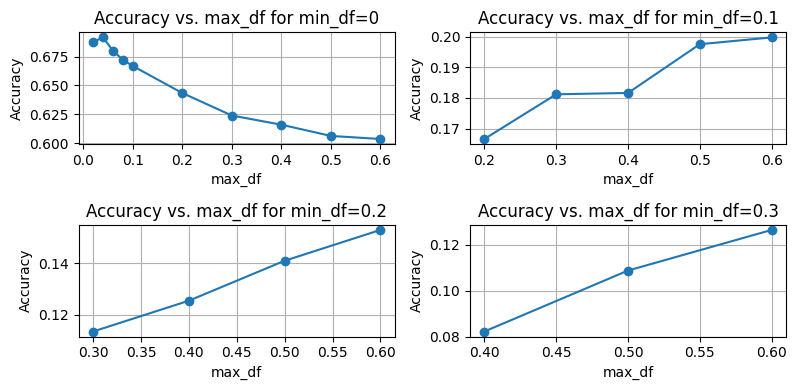

Best Parameters (Basic Preprocessing) - min_df=0, max_df=0.04, Accuracy: 0.6915598762704375


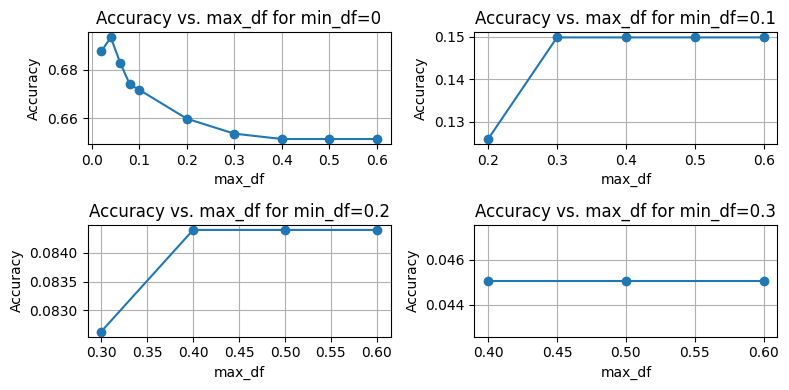

Best Parameters (Normal Preprocessing) - min_df=0, max_df=0.04, Accuracy: 0.6933274414494034


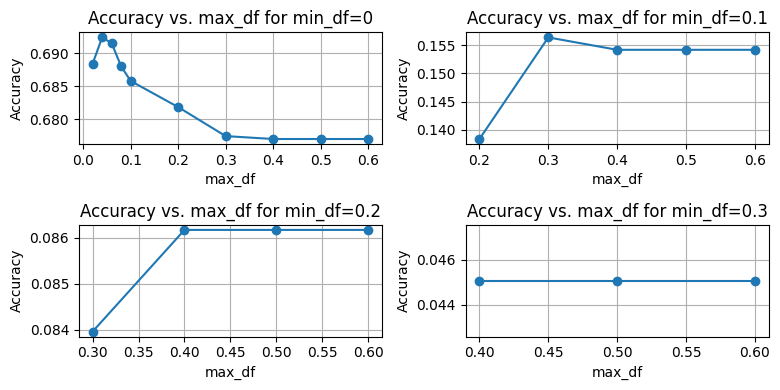

Best Parameters (Complete Preprocessing) - min_df=0, max_df=0.04, Accuracy: 0.6924436588599204


In [27]:
# Basic preprocess
best_min_df_basic, best_max_df_basic, best_accuracy_basic = find_min_max_df(basic_preprocessed_train_data, basic_preprocessed_train_data_cv, y_train_for_cv,twenty_train_y)
print(f"Best Parameters (Basic Preprocessing) - min_df={best_min_df_basic}, max_df={best_max_df_basic}, Accuracy: {best_accuracy_basic}")

# Normal preprocess
best_min_df_normal, best_max_df_normal, best_accuracy_normal = find_min_max_df(normal_preprocessed_train_data, normal_preprocessed_train_data_cv, y_train_for_cv,twenty_train_y)
print(f"Best Parameters (Normal Preprocessing) - min_df={best_min_df_normal}, max_df={best_max_df_normal}, Accuracy: {best_accuracy_normal}")

# Complete preprocess
best_min_df_complete, best_max_df_complete, best_accuracy_complete = find_min_max_df(complete_preprocessed_train_data, complete_preprocessed_train_data_cv, y_train_for_cv,twenty_train_y)
print(f"Best Parameters (Complete Preprocessing) - min_df={best_min_df_complete}, max_df={best_max_df_complete}, Accuracy: {best_accuracy_complete}")

# GridSearch

Probamos encontrar el parámetro alpha a través de GridSearch considerando los mind_df y max_df calculados anteriormente.

En este caso se utiliza todo el train (twenty_train_full) y utilizamos el test (twenty_train)


Se realiza este procedimiento 3 veces, en representación de los 3 'filtros' realizados con anterioridad: **complete**, **basic** y **normal**.

## Con sólo alpha y los mindf y maxdf anteriores


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

param_grid = {
    'clf__alpha': (0.0001, 0.001, 0.01, 1.0)
}


#For complete

text_clf_complete = Pipeline([('vect', CountVectorizer(min_df = 0, max_df = 0.04)),
                     ('tfidf', TfidfTransformer()), #helps with the accuracy
                     ('clf', MultinomialNB())])


text_clf_complete.fit(complete_preprocessed_train_data_full, twenty_train_full.target)
grid_search = GridSearchCV(text_clf_complete, param_grid, scoring='accuracy')

grid_search.fit(complete_preprocessed_train_data_full, twenty_train_full.target)



cv_for_frequency = CountVectorizer()
cv_fit = cv_for_frequency.fit_transform(complete_preprocessed_train_data_full)


print(cv_fit.toarray())



print("Best Parameters for complete:", grid_search.best_params_)
test_accuracy = grid_search.score(complete_preprocessed_test_data, twenty_test.target)
print("Test Accuracy for complete:", test_accuracy)
test_accuracy_prom=sum(np.array(grid_search.predict(complete_preprocessed_test_data))==np.array(twenty_test["target"]))/len(twenty_test["target"])*100
print("Test Accuracy by Sum for complete:", test_accuracy_prom)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Best Parameters for complete: {'clf__alpha': 0.01}
Test Accuracy for complete: 0.6791024960169941
Test Accuracy by Sum for complete: 67.91024960169942


In [31]:
#For basic

text_clf_basic = Pipeline([('vect', CountVectorizer(min_df = 0, max_df = 0.04)),
                     ('tfidf', TfidfTransformer()), #helps with the accuracy
                     ('clf', MultinomialNB())])


text_clf_basic.fit(basic_preprocessed_train_data_full, twenty_train_full.target)
grid_search = GridSearchCV(text_clf_basic, param_grid, scoring='accuracy')

grid_search.fit(basic_preprocessed_train_data_full, twenty_train_full.target)


print("Best Parameters for basic:", grid_search.best_params_)
test_accuracy = grid_search.score(basic_preprocessed_test_data, twenty_test.target)
print("Test Accuracy for basic:", test_accuracy)
test_accuracy_prom=sum(np.array(grid_search.predict(basic_preprocessed_test_data))==np.array(twenty_test["target"]))/len(twenty_test["target"])*100
print("Test Accuracy by Sum for basic:", test_accuracy_prom)

Best Parameters for basic: {'clf__alpha': 0.01}
Test Accuracy for basic: 0.6975570897503983
Test Accuracy by Sum for basic: 69.75570897503984


In [32]:
#For normal

text_clf_normal = Pipeline([('vect', CountVectorizer(min_df = 0, max_df = 0.04)),
                     ('tfidf', TfidfTransformer()), #helps with the accuracy
                     ('clf', MultinomialNB())])


text_clf_basic.fit(normal_preprocessed_train_data_full, twenty_train_full.target)
grid_search = GridSearchCV(text_clf_normal, param_grid, scoring='accuracy')

grid_search.fit(normal_preprocessed_train_data_full, twenty_train_full.target)


print("Best Parameters for normal:", grid_search.best_params_)
test_accuracy = grid_search.score(normal_preprocessed_test_data, twenty_test.target)
print("Test Accuracy for normal:", test_accuracy)
test_accuracy_prom=sum(np.array(grid_search.predict(normal_preprocessed_test_data))==np.array(twenty_test["target"]))/len(twenty_test["target"])*100
print("Test Accuracy by Sum for normal:", test_accuracy_prom)

Best Parameters for normal: {'clf__alpha': 0.01}
Test Accuracy for normal: 0.694768985661179
Test Accuracy by Sum for normal: 69.4768985661179


##Con alpha, mindf y maxdf

También se pueden conseguir los parámetros de min_df y max_df a través de GridSearch, como se muestra a continuación:

Se realiza este procedimiento 3 veces, en representación de los 3 'filtros' realizados con anterioridad: **complete**, **basic** y **normal**.

In [33]:
#For Complete
param_grid = {
    'vect__min_df': (0.01, 0.1, 1),
    'vect__max_df': (0.5, 0.75, 1.0),
    'clf__alpha': (0.0001, 0.001, 0.01)
}


text_clf_complete = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()), #helps with the accuracy
                     ('clf', MultinomialNB())])

text_clf_complete.fit(complete_preprocessed_train_data_full, twenty_train_full.target)




text_clf_complete.fit(complete_preprocessed_train_data_full, twenty_train_full.target)
grid_search = GridSearchCV(text_clf_complete, param_grid, scoring='accuracy')

grid_search.fit(complete_preprocessed_train_data_full, twenty_train_full.target)


print("Best Parameters for complete:", grid_search.best_params_)
test_accuracy = grid_search.score(complete_preprocessed_test_data, twenty_test.target)
print("Test Accuracy for complete:", test_accuracy)
test_accuracy_prom=sum(np.array(grid_search.predict(complete_preprocessed_test_data))==np.array(twenty_test["target"]))/len(twenty_test["target"])*100
print("Test Accuracy by Sum for complete:", test_accuracy_prom)




Best Parameters for complete: {'clf__alpha': 0.01, 'vect__max_df': 0.5, 'vect__min_df': 1}
Test Accuracy for complete: 0.6878651088688263
Test Accuracy by Sum for complete: 68.78651088688264


In [34]:
#For basic
text_clf_basic = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()), #helps with the accuracy
                     ('clf', MultinomialNB())])


text_clf_basic.fit(basic_preprocessed_train_data_full, twenty_train_full.target)
grid_search = GridSearchCV(text_clf_basic, param_grid, scoring='accuracy')

grid_search.fit(basic_preprocessed_train_data_full, twenty_train_full.target)


print("Best Parameters for basic:", grid_search.best_params_)
test_accuracy = grid_search.score(basic_preprocessed_test_data, twenty_test.target)
print("Test Accuracy for basic:", test_accuracy)
test_accuracy_prom=sum(np.array(grid_search.predict(basic_preprocessed_test_data))==np.array(twenty_test["target"]))/len(twenty_test["target"])*100
print("Test Accuracy by Sum for basic:", test_accuracy_prom)

Best Parameters for basic: {'clf__alpha': 0.01, 'vect__max_df': 0.5, 'vect__min_df': 1}
Test Accuracy for basic: 0.7000796601168349
Test Accuracy by Sum for basic: 70.0079660116835


In [35]:
#For normal

text_clf_normal = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()), #helps with the accuracy
                     ('clf', MultinomialNB())])


text_clf_basic.fit(normal_preprocessed_train_data_full, twenty_train_full.target)
grid_search = GridSearchCV(text_clf_normal, param_grid, scoring='accuracy')

grid_search.fit(normal_preprocessed_train_data_full, twenty_train_full.target)


print("Best Parameters for normal:", grid_search.best_params_)
test_accuracy = grid_search.score(normal_preprocessed_test_data, twenty_test.target)
print("Test Accuracy for normal:", test_accuracy)
test_accuracy_prom=sum(np.array(grid_search.predict(normal_preprocessed_test_data))==np.array(twenty_test["target"]))/len(twenty_test["target"])*100
print("Test Accuracy by Sum for normal:", test_accuracy_prom)

Best Parameters for normal: {'clf__alpha': 0.01, 'vect__max_df': 0.5, 'vect__min_df': 1}
Test Accuracy for normal: 0.701141795007966
Test Accuracy by Sum for normal: 70.11417950079661


# Búsquedad de Hiperparámetros con Regresión Logística

Vamos ahora a realizar el mismo ejemplo anterior para complete, pero con otro modelo. En este caso con Regresión logísitica. Lo hacemos primero con CV y luego con el full

In [36]:
from sklearn.linear_model import  LogisticRegression
# FINDING min_df and max_df
def find_min_max_df(preprocessed_train_data, preprocessed_test_data,y_train_for_cv,twenty_train_y , debug=False):
    # Finding min_df and max_df
    best_accuracy = 0
    best_min_df = None
    best_max_df = None

    # Values to test
    min_df_values = [0, 0.1, 0.2, 0.3]
    max_df_values = [0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

    # Create a single figure for all plots
    fig, axs = plt.subplots(len(min_df_values)//2, len(min_df_values)//2, figsize=(8, 4))

    for idx, min_df in enumerate(min_df_values):
        row = idx // 2
        col = idx % 2
        accuracies = []  # Keep accuracies for each max_df
        for max_df in max_df_values:
            if min_df < max_df:
                # Data vectorization
                vectorizer_train = CountVectorizer(min_df=min_df, max_df=max_df)
                X_train = vectorizer_train.fit_transform(preprocessed_train_data)
                vectorizer_test = CountVectorizer(vocabulary=vectorizer_train.vocabulary_)
                X_test = vectorizer_test.transform(preprocessed_test_data)

                # Training
                clf = LogisticRegression(max_iter = 300)
                clf.fit(X_train, twenty_train_y)  #antes decía twenty_train

                # Evaluation
                accuracy = np.mean(clf.predict(X_test) == y_train_for_cv) #antes decía twenty_test.target
                accuracies.append(accuracy)

                # Print accuracy if debug mode is enabled
                if debug:
                    print(f"min_df={min_df}, max_df={max_df} - Accuracy: {accuracy}")

                # Update parameters
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_min_df = min_df
                    best_max_df = max_df

            else:
                accuracies.append(None)

        # Plot accuracies for current min_df
        axs[row, col].plot(max_df_values, accuracies, marker='o')
        axs[row, col].set_title(f'Accuracy vs. max_df for min_df={min_df}')
        axs[row, col].set_xlabel('max_df')
        axs[row, col].set_ylabel('Accuracy')
        axs[row, col].grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap of subplots
    plt.show()

    return best_min_df, best_max_df, best_accuracy


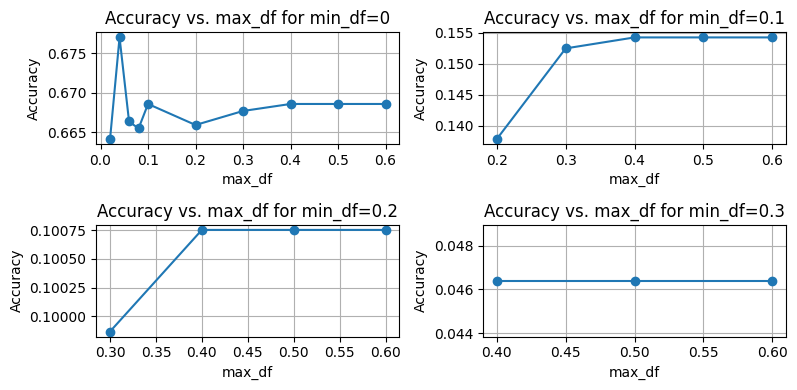

Best Parameters (Complete Preprocessing) - min_df=0, max_df=0.04, Accuracy: 0.6769774635439681


In [37]:

# Complete preprocess
best_min_df_complete, best_max_df_complete, best_accuracy_complete = find_min_max_df(complete_preprocessed_train_data, complete_preprocessed_train_data_cv, y_train_for_cv,twenty_train_y)
print(f"Best Parameters (Complete Preprocessing) - min_df={best_min_df_complete}, max_df={best_max_df_complete}, Accuracy: {best_accuracy_complete}")

# Grid Search





In [38]:


#For Complete
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],  # C = parámetro de regularización

}

text_clf_complete = Pipeline([('vect', CountVectorizer(min_df=0, max_df=0.04)),
                     ('clf', LogisticRegression(max_iter = 300))])


grid_search = GridSearchCV(text_clf_complete, param_grid, scoring='accuracy')

grid_search.fit(complete_preprocessed_train_data_full, twenty_train_full.target)


print("Best Parameters for complete with logistic regression:", grid_search.best_params_)
test_accuracy = grid_search.score(complete_preprocessed_test_data, twenty_test.target)
print("Test Accuracy for complete with logistic regression:", test_accuracy)
test_accuracy_prom=sum(np.array(grid_search.predict(complete_preprocessed_test_data))==np.array(twenty_test["target"]))/len(twenty_test["target"])*100
print("Test Accuracy by Sum for complete with logistic regression:", test_accuracy_prom)





Best Parameters for complete with logistic regression: {'clf__C': 0.1}
Test Accuracy for complete with logistic regression: 0.6374137015400956
Test Accuracy by Sum for complete with logistic regression: 63.74137015400956
